In [1]:
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
from utils.io import load_json, load
from utils.Logger import Logger
from utils.experiment_evaluator import Evaluator
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

data_directory = '../experiments_results/'
experiments = [dI for dI in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, dI))]
# experiments = [dI for dI in experiments if not dI[0] == '_']
experiments.sort(key=lambda x: x.lower())

In [2]:
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid") 

In [3]:
def get_styles(exp):
    exp = exp.lower()
    if 'ar_lstm' in exp:
        style = '-'
    elif 'convls' in exp:
        style = ':'
    elif 'resnet' in exp:
        style =  '--'
    else:
        style = '-.'
    return style

# Dataframe creation from pickles

In [130]:
test_set = 'Test'

In [131]:
experiment = 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7'
ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
ev.get_rmse_values_previous_frame().head()

,mean,std
Frames,,
1,0.032785,0.008058
2,0.033247,0.008146
3,0.033644,0.008272
4,0.033907,0.008506
5,0.034210,0.008524


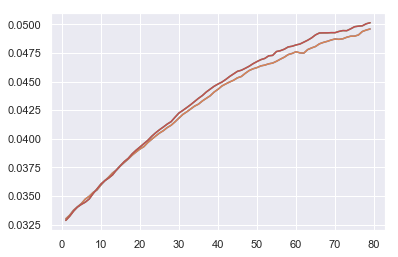

In [145]:
experiment = 'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_16h'
ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
df = ev.get_rmse_values_previous_frame()
plt.plot(df['mean'])
experiment = 'ar_lstm_batch_16_samples_5_in_5_out_20_normal_lr_0.0001'
ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
plt.plot(df['mean'])
experiment = 'resnet_batch_16_samples_5_in_5_out_10_normal_lr_0.001'
ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
df = ev.get_rmse_values_previous_frame()
plt.plot(df['mean'])


df = ev.get_rmse_values_previous_frame()
plt.plot(df['mean'])
df = ev.get_rmse_values()
# plt.plot(df['mean'])

,mean,std
Frames,,
1,0.033102,0.008165
2,0.033377,0.008272
3,0.033821,0.008472
4,0.034031,0.008757
5,0.034389,0.008838


In [28]:
testset_exp_eval = {}
test_sets = ["Test", "Lines", "Double_Drop", "Illumination_135", "Shallow_Depth", "Smaller_Tub", "Bigger_Tub"]
for test_set in test_sets:
    print(test_set)
    testset_exp_eval[test_set] = {}
    for experiment in experiments:
        try:
            ev = load('../experiments_results/' + experiment + '/pickles/evaluator_%s_sp_15.pickle' % test_set)
            df = ev.get_rmse_values()
            x = df.index.values
            y_error = df['mean'].values
            df = ev.get_ssim_values()
            y_ssim = df['mean'].values
            md = load_json('../experiments_results/' + experiment + '/pickles/metadata.pickle.json')
            md['args']['belated'] = False
            testset_exp_eval[test_set][experiment] = {'frame': x, 'error': y_error, 'ssim':y_ssim, 'args': md['args']}
        except:
#             print(experiment)
            pass
        try:
            ev = load('../experiments_results/' + experiment + '/pickles/belated_evaluator_%s_sp_15.pickle' %test_set)
            df = ev.get_rmse_values()
            x = df.index.values
            y_error = df['mean'].values
            df = ev.get_ssim_values()
            y_ssim = df['mean'].values
            md = load_json('../experiments_results/' + experiment + '/pickles/metadata.pickle.json')
            md['args']['belated'] = False
            testset_exp_eval[test_set][experiment+'_belated'] = {'frame': x, 'error': y_error, 'ssim':y_ssim, 'args': md['args']}
        except:
            pass

Test
Lines
Double_Drop
Illumination_135
Shallow_Depth
Smaller_Tub
Bigger_Tub


# Comparing results

In [29]:
test_set = 'Test'
evaluators = testset_exp_eval[test_set]

In [30]:
# df = pd.DataFrame.from_dict({'frame': ev['frame'], 'error': ev['error'], 'ssim': ev['ssim']})
# bins = pd.cut(df['frame'], [-1, 9, 19, 29, 39, 49, 59, 69, 79], )
# dfb = df.groupby(bins)['error'].agg(['mean']).round(3).reset_index(drop=True)
# dfb.rename(columns={"mean": exp}, inplace=True)
# # dfb

In [31]:
# bins = 10*[0] + 10*[1] + 10*[2] + 10*[3] + 10*[4] + 10*[5] + 10*[6] + 10*[7]
# df['bins'] = bins
# dfb = df.groupby(bins)[['error','ssim']].agg('mean').round(3).reset_index(drop=True)
# dfb['exp'] = exp
# dfb = dfb.reset_index()
# dfb = dfb.pivot(index='exp', columns='index')

In [35]:
dff = None
for exp, ev in evaluators.items():
#     print(exp)
    df = pd.DataFrame.from_dict({'frame': ev['frame'], 'error': ev['error']})
    bins = pd.cut(df['frame'], [-1, 9, 19, 29, 39, 49, 59, 69, 79], )
    dfb = df.groupby(bins)['error'].agg(['mean']).round(3).reset_index(drop=True)
    dfb.rename(columns={"mean": exp}, inplace=True)
    if dff is None:
        dff = dfb
    else:
        dff = dff.join(dfb)
dff = dff.T

dff['short'] = ((dff[0] + dff[1] + dff[2])/3).round(3)
dff['short-med'] = ((dff[0] + dff[1] + dff[2] + dff[3] + dff[4])/5).round(3)
dff['med'] = ((dff[3] + dff[4] + dff[5])/3).round(3)
dff['long'] = ((dff[5] + dff[6] + dff[7])/3).round(3)
dff['mean'] = dff.mean(axis=1).round(3)


for exp in dff.index:
    args = evaluators[exp]['args']
    if 'dataset' in args:
        dff.loc[exp, 'dataset'] = args['dataset']
    else:
        dff.loc[exp, 'dataset'] = 'original'
    dff.loc[exp, 'model'] = args['model_type']
    dff.loc[exp, 'batch'] = args['batch_size']
    dff.loc[exp, 'samples'] = args['samples_per_sequence']
    dff.loc[exp, 'in'] = args['num_input_frames']
    dff.loc[exp, 'out'] = args['num_output_frames']
    dff.loc[exp, 'LR'] = args['learning_rate']
    dff.loc[exp, 'patience'] = args['scheduler_patience']
    dff.loc[exp, 'belated'] = args['belated']
    
    if '16h' in args['experiment_name']:
        time = 16
    elif '16h' in args['experiment_name']:
        time = 24
    else:
        time = 8
        
    dff.loc[exp, 'time'] = time
    
    other = args['experiment_name'].split('_')[-1]
    if not(other == 2 or other == 'c'):
        other = 'na'
    dff.loc[exp, 'other'] = other

# Find best per model 

In [36]:
dff_fixed_tub = dff[dff['dataset'] == 'fixed_tub']
dff_original = dff[dff['dataset'] == 'original']
dff_original.columns

# exp_to_plot = dff_fixed_tub.groupby(["model"])["short"].idxmin().values
# exp_to_plot = dff_fixed_tub.index.values

Index([          0,           1,           2,           3,           4,
                 5,           6,           7,     'short', 'short-med',
             'med',      'long',      'mean',   'dataset',     'model',
           'batch',   'samples',        'in',       'out',        'LR',
        'patience',   'belated',      'time',     'other'],
      dtype='object')

In [37]:
best_exps_per_segment = {}
exp_to_plot = []
columns = dff_original.columns[:13]
for i in columns:
    best_exps_per_segment[i] = list(dff_original.groupby("model")[i].idxmin().values)
    exp_to_plot += list(dff_original.groupby("model")[i].idxmin().values)
exp_to_plot = list(set(exp_to_plot))
exp_to_plot.sort()

In [38]:
best_exps_per_model_segment = {}
columns = dff_original.columns[:13]

for m in dff.model.unique():
    best_exps_per_model_segment[m] = {}
    dff_model = dff_original[dff_original.model==m]
    for c in columns:
        best_exps_per_model_segment[m][c] = list(dff_model.groupby("model")[c].idxmin().values)[0]

In [39]:
best_exps_per_model = {}

for k,v in best_exps_per_model_segment.items():
    best_exps_per_model[k] = list(set(v.values()))
    
# best_exps_per_model

In [40]:
# best_exps_per_model_segment

# Plot the best exp of each model for a specific segment

In [80]:
segment = 'mean'
test_set = 'Lines'


traces = []
evaluators = testset_exp_eval[test_set]
for i, exp in enumerate(best_exps_per_segment[segment]):
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['ssim']
    traces.append(go.Scatter(x=x, y=y, name= exp, 
                             marker_color = plotly.colors.DEFAULT_PLOTLY_COLORS[i%10],
                             opacity=1))

layout = dict(legend=dict(y=0.9, font=dict( size=6)), title='%s set performance' %test_set,
             xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# Plot all exps for model

In [50]:
dff.model.unique()

array(['ar_lstm', 'convlstm', 'predrnn', 'resnet', 'resnet_dilated',
       'unet'], dtype=object)

In [96]:
model_to_plot = 'convlstm'
test_sets_plot = [test_sets[6]]

traces = []
for k, test_set in enumerate(test_sets_plot):
    evaluators = testset_exp_eval[test_set]
    for i, exp in enumerate(list(dff[dff.model==model_to_plot].index.values)):
        ev = evaluators[exp]
        x = ev['frame']
        y = ev['ssim']
        traces.append(go.Scatter(x=x, y=y, name=exp, 
                                 marker_color = plotly.colors.DEFAULT_PLOTLY_COLORS[i % 10],
                                 opacity=1/(k+1)))

layout = dict(legend=dict(y=0.9, font=dict( size=6)), title='%s set performance' %test_set,
             xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# Plot all the best experiments for each model

In [54]:
model_to_plot = 'predrnn'
test_set = 'Test'

traces = []
evaluators = testset_exp_eval[test_set]
for i, exp in enumerate(best_exps_per_model[model_to_plot]):
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['ssim']
    traces.append(go.Scatter(x=x, y=y, name=exp, 
                             marker_color = plotly.colors.DEFAULT_PLOTLY_COLORS[i],
                             opacity=1/(k+1)))
    
layout = dict(legend=dict(y=0.9, font=dict( size=6)), title='%s set performance' %test_set,
             xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))


ff = plotly.offline.iplot({"data": traces, "layout": layout })

In [770]:
# AR LSTM
# ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_5
# Best in Shallow_Depth: ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001
# All suck in Smaller Tub

# ConvLSTM
# convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_16h_c_belated
# All suck in Smaller Tub

# PredRNN
# predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_3_belated

# ResNet
# resnet_batch_16_samples_5_in_5_out_10_normal_lr_0.001

# U-Net
# unet_batch_16_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_7

# Plot generalization of best exps for model

In [771]:
model_to_plot = 'predrnn'
test_sets_plot = [test_sets[5]]

traces = []
for k, test_set in enumerate(test_sets_plot):
    evaluators = testset_exp_eval[test_set]
    for i, exp in enumerate(best_exps_per_model[model_to_plot]):
        ev = evaluators[exp]
        x = ev['frame']
        y = ev['error']
        traces.append(go.Scatter(x=x, y=y, name=exp, 
                                 marker_color = plotly.colors.DEFAULT_PLOTLY_COLORS[i],
                                 opacity=1/(k+1)))

layout = dict(legend=dict(y=0.9, font=dict( size=6)), title='%s set performance' %test_set,
             xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# Plot all generalization for one experiment

In [848]:
model = 'ar_lstm'
exp = best_exps_per_model[model][2]
# best_exps_per_segment['mean'][2]

traces = []
for ts in test_sets:
    evaluators = testset_exp_eval[ts]
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=ts))

layout = dict(legend=dict(y=0.9, font=dict( size=20)), title=exp,
                xaxis=dict(title='Time step'),
             yaxis=dict(title='RMSE'))

ff = plotly.offline.iplot({"data": traces, "layout": layout })

In [773]:
exp = best_exps_per_model[model][3]

traces = []
for ts in test_sets:
    evaluators = testset_exp_eval[ts]
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=ts))

layout = dict(legend=dict(y=0.9, font=dict( size=20)), title=exp)

ff = plotly.offline.iplot({"data": traces, "layout": layout })

In [774]:
exp = best_exps_per_model[model][2]

traces = []
for ts in test_sets:
    evaluators = testset_exp_eval[ts]
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=ts))

layout = dict(legend=dict(y=0.9, font=dict( size=20)), title=exp)

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# Plot generalization of specific model

In [775]:
exp = 'unet_batch_16_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_16h_patience_7'
# exp = 'unet_batch_16_samples_5_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7'
# exp = 'unet_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_original_24h_patience_7'

traces = []
for ts in test_sets:
    evaluators = testset_exp_eval[ts]
    ev = evaluators[exp]
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=ts))

layout = dict(legend=dict(y=0.9, font=dict( size=20)), title=exp)

ff = plotly.offline.iplot({"data": traces, "layout": layout })

# q-grid

In [588]:
import qgrid
qgrid.show_grid(dff[dff.columns[~dff.columns.isin([2,3,4,5,6,7])]], grid_options={'forceFitColumns': False, 'defaultColumnWidth': 70})

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

# All models

In [550]:
test_set = 'Test'
evaluators = testset_exp_eval[test_set]

traces = []
for exp, ev in evaluators.items():
    x = ev['frame']
    y = ev['error']
    traces.append(go.Scatter(x=x, y=y, name=exp,
                            visible = 'legendonly'))
layout = dict(
    legend=dict(
        y=0.9,
        font=dict(
            size=6)))

ff = plotly.offline.iplot({
        "data": traces,
        "layout": layout
    })

# Keep only the best exp of each model

In [801]:
all_exp_2 = len(dff[(dff.dataset=='original') & (dff.belated==False)])

In [780]:
all_exp = dff[dff.dataset=='original'].index.values

In [803]:
keep_exp = dff[dff.dataset=='original'].groupby('model')['mean'].nsmallest(5).index.values
keep_exp = [b for a,b in keep_exp]

In [802]:
dff[dff.dataset=='fixed_tub'].index.values

array(['ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub',
       'ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_belated',
       'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_dataset_fixed_tub',
       'convlstm_batch_8_samples_5_in_5_out_10_normal_lr_0.001_dataset_fixed_tub_belated',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_8h',
       'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_8h_belated',
       'resnet_batch_16_samples_5_in_5_out_10_normal_lr_0.001_dataset_fixed_tub',
       'unet_batch_16_samples_5_in_5_out_20_normal_lr_0.0001_dataset_fixed_tub_8h_patience_7'],
      dtype=object)

# Seaborn plot

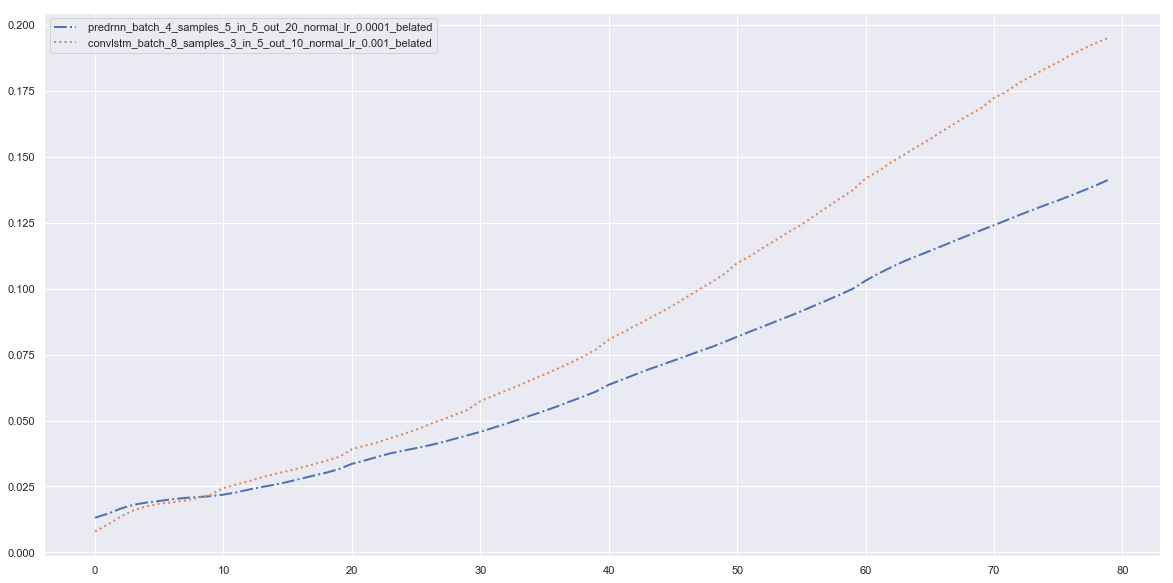

In [58]:
exps_to_show = ['predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_belated',
               'convlstm_batch_8_samples_3_in_5_out_10_normal_lr_0.001_belated']

fig = plt.figure(figsize=(20,10)).add_axes()
for exp in exps_to_show:
    ev = evaluators[exp]
    df = ev.get_rmse_values()
    x = df.index.values
    y = df['mean'].values
    style = get_styles(exp)
    plt.plot(x, y, label=' '+exp, linewidth=2, linestyle=style)
plt.legend()
plt.show()

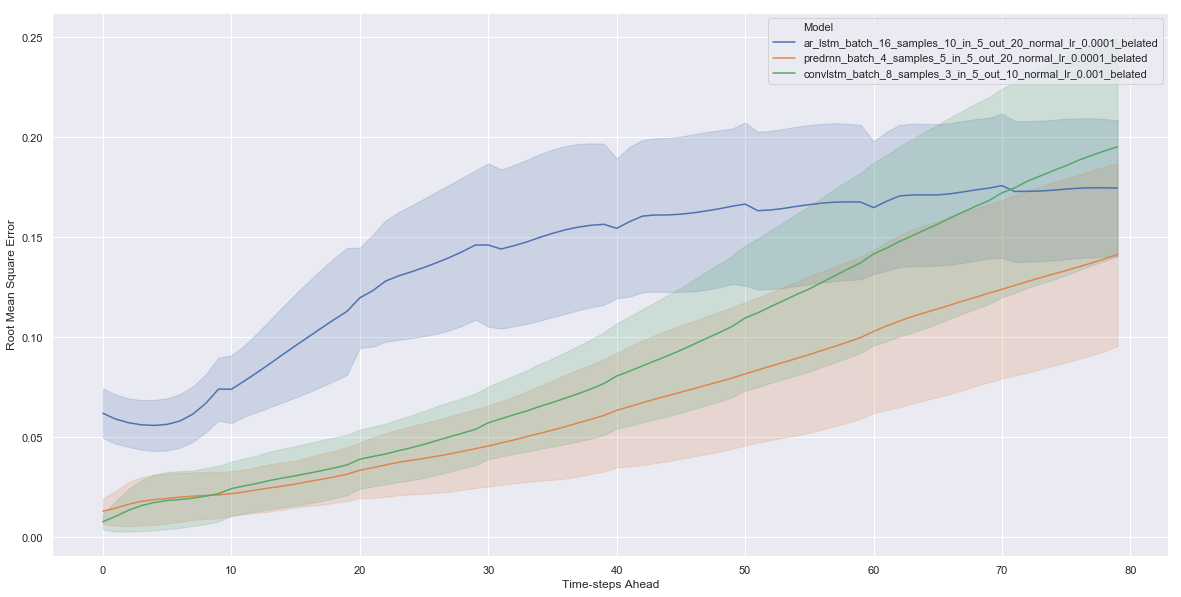

In [90]:
exps_to_show = ['ar_lstm_batch_16_samples_10_in_5_out_20_normal_lr_0.0001_belated',
                'predrnn_batch_4_samples_5_in_5_out_20_normal_lr_0.0001_belated',
               'convlstm_batch_8_samples_3_in_5_out_10_normal_lr_0.001_belated']

fig = plt.figure(figsize=(20,10)).add_axes()
dfs = []
for exp in exps_to_show:
    ev = evaluators[exp]
#     df = ev.get_rmse_values()
#     x = df.index.values
#     y = df['mean'].values
#     style = get_styles(exp)
#     plt.plot(x, y, label=' '+exp, linewidth=2, linestyle=style)

    all_data={"Time-steps Ahead":        ev.state['MSE_frame'],
    "Root Mean Square Error":  ev.state['MSE_val'],
    "Scoring Type":            ev.state['MSE_hue']}
    df = pd.DataFrame.from_dict(all_data)
    df['Model'] = exp
#     fig = plt.figure().add_axes()
    dfs.append(df)
dff = pd.concat(dfs)
sns.lineplot(x="Time-steps Ahead", y="Root Mean Square Error", hue="Model", data=dff, ax=fig, ci='sd')

In [33]:
# fig = plt.figure(figsize=(20,20)).add_axes()

# for exp, ev in evaluators.items():
#     df = ev.get_ssim_values()
    
#     sns.lineplot(x=df.index, y="mean", hue="Network",
#              data=df, ax=fig, ci='sd')
#     x = df.index.values
#     y = df['mean'].values
#     style = get_styles(exp)
#     plt.plot(x, y, label=exp, linewidth=2, linestyle=style)
# plt.legend()
# plt.show()